In [1]:
#IMPORTING ALL THE NECESSARY PACKAGES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Load the dataset
data = pd.read_excel('teoporiskfactors.xlsx') 
data.head(3)

,measure_id,measure_name,location_id,location_name,sex_id,sex_name,age_id,age_name,cause_id,cause_name,rei_id,rei_name,metric_id,metric_name,year,val,upper,lower
0,1,Deaths,195,Namibia,1,Male,159,10-24 years,494,Stroke,108,High body-mass index,2,Percent,2012,0.005154,0.024124,-0.004212
1,1,Deaths,195,Namibia,2,Female,159,10-24 years,494,Stroke,108,High body-mass index,2,Percent,2012,0.019004,0.060940,0.000080
2,1,Deaths,195,Namibia,1,Male,159,10-24 years,494,Stroke,108,High body-mass index,2,Percent,2013,0.005538,0.023858,-0.004467


In [3]:
# Get the total number of elements in the DataFrame
total_elements = data.size
print(total_elements)

# Get the dimensions of the DataFrame (rows, columns)
dimensions = data.shape
print(dimensions)

108000
(6000, 18)


In [4]:
# Check for missing values
print(data.isnull().sum())

measure_id       0
measure_name     0
location_id      0
location_name    0
sex_id           0
sex_name         0
age_id           0
age_name         0
cause_id         0
cause_name       0
rei_id           0
rei_name         0
metric_id        0
metric_name      0
year             0
val              0
upper            0
lower            0
dtype: int64


In [5]:
#Describe the DataFrame and display it neatly
display(data.describe())

,measure_id,location_id,sex_id,age_id,cause_id,rei_id,metric_id,year,val,upper,lower
count,6000.000000,6000.0,6000.000000,6000.000000,6000.0,6000.000000,6000.0,6000.000000,6000.000000,6000.000000,6000.000000
mean,2.500000,195.0,1.500000,34.853333,494.0,157.320000,2.0,2016.500000,0.184702,0.276585,0.092179
std,1.118127,0.0,0.500042,56.283684,0.0,104.893715,0.0,2.872521,0.198093,0.262944,0.122781
min,1.000000,195.0,1.000000,10.000000,494.0,99.000000,2.0,2012.000000,0.004927,0.022871,-0.004467
25%,1.750000,195.0,1.000000,13.000000,494.0,105.000000,2.0,2014.000000,0.051384,0.092033,0.014806
50%,2.500000,195.0,1.500000,17.000000,494.0,107.000000,2.0,2016.500000,0.100884,0.160337,0.034676
75%,3.250000,195.0,2.000000,30.000000,494.0,108.000000,2.0,2019.000000,0.165269,0.309134,0.104876
max,4.000000,195.0,2.000000,235.000000,494.0,367.000000,2.0,2021.000000,0.673430,0.841276,0.508786


In [6]:
# Explore unique values in relevant columns
print(data['measure_name'].unique())

['Deaths' 'DALYs (Disability-Adjusted Life Years)'
 'YLDs (Years Lived with Disability)' 'YLLs (Years of Life Lost)']


In [7]:
print(data['rei_name'].unique())

['High body-mass index' 'High systolic blood pressure'
 'High fasting plasma glucose' 'High LDL cholesterol' 'Smoking']


In [8]:
print(data['cause_name'].unique())

['Stroke']


In [9]:
# Drop the all the columns that are not contributing anything to the predictions
df = data.drop(columns=['upper', 'lower', 'measure_id', 'location_id', 'sex_id', 'age_id', 'cause_id', 'metric_id', 'location_name', 'cause_name', 'rei_id', 'metric_name'])

# Display the first few rows of the modified DataFrame to verify
df.head(3)

,measure_name,sex_name,age_name,rei_name,year,val
0,Deaths,Male,10-24 years,High body-mass index,2012,0.005154
1,Deaths,Female,10-24 years,High body-mass index,2012,0.019004
2,Deaths,Male,10-24 years,High body-mass index,2013,0.005538


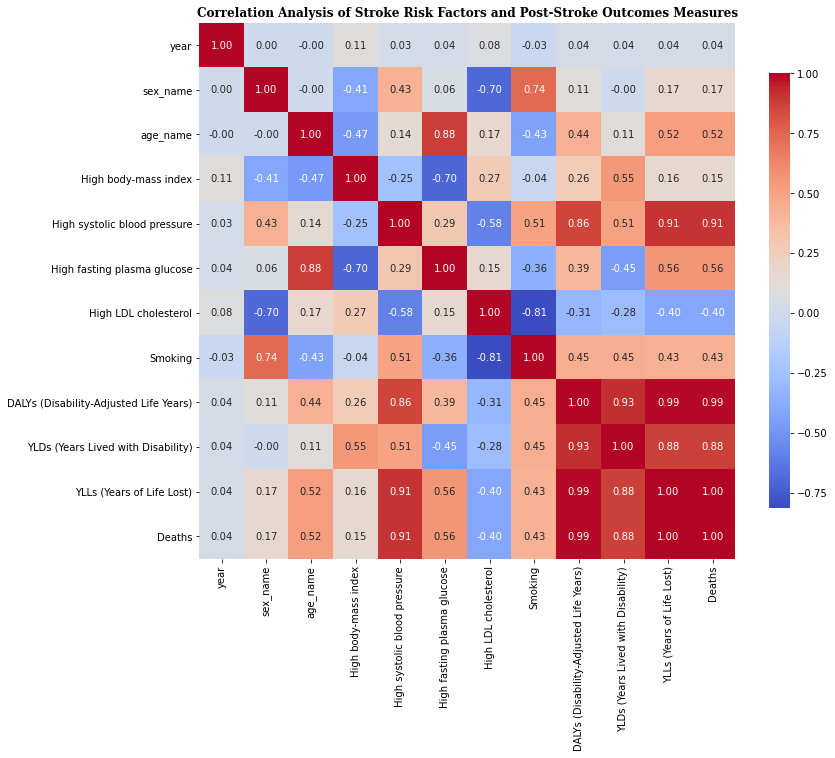

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define risk factors
risk_factors = ['High body-mass index', 'High systolic blood pressure', 
                'High fasting plasma glucose', 'High LDL cholesterol', 'Smoking']

# Define post-stroke outcome measures (including Deaths now)
outcome_measures = ['DALYs (Disability-Adjusted Life Years)', 
                    'YLDs (Years Lived with Disability)', 
                    'YLLs (Years of Life Lost)', 
                    'Deaths']  

# Filter the DataFrame for rows with risk factors and outcome measures
df_risk_outcomes = df[df['rei_name'].isin(risk_factors) | df['measure_name'].isin(outcome_measures)]

# Group by 'year', 'sex_name', 'age_name', 'rei_name', and aggregate the 'val' column by mean for risk factors
df_grouped = df_risk_outcomes.groupby(['year', 'sex_name', 'age_name', 'rei_name'], as_index=False)['val'].mean()

# Pivot the data to create a matrix for risk factors
df_risk_pivot = df_grouped.pivot_table(index=['year', 'sex_name', 'age_name'], columns='rei_name', values='val').reset_index()

# Group by 'year', 'sex_name', 'age_name', and 'measure_name', and aggregate the 'val' column by mean for outcomes
df_outcome_grouped = df_risk_outcomes.groupby(['year', 'sex_name', 'age_name', 'measure_name'], as_index=False)['val'].mean()

# Pivot the data to create a matrix for outcomes
df_outcome_pivot = df_outcome_grouped.pivot_table(index=['year', 'sex_name', 'age_name'], columns='measure_name', values='val').reset_index()

# Combine both pivot tables (risk factors and outcomes)
df_combined = pd.merge(df_risk_pivot, df_outcome_pivot, on=['year', 'sex_name', 'age_name'], how='outer')

# Convert categorical columns 'sex_name' and 'age_name' into numeric
df_combined['sex_name'] = df_combined['sex_name'].astype('category').cat.codes
df_combined['age_name'] = df_combined['age_name'].astype('category').cat.codes

# Select relevant columns for correlation (year, sex_name, age_name, risk factors, and outcomes including Deaths)
columns_of_interest = ['year', 'sex_name', 'age_name'] + risk_factors + outcome_measures
df_corr = df_combined[columns_of_interest]

# Calculate the correlation matrix of the selected features
corr_matrix = df_corr.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Analysis of Stroke Risk Factors and Post-Stroke Outcomes Measures', fontsize=12, fontfamily='serif', fontweight='bold', ha='center')
plt.show()

In [11]:
##################################### DATA VISUALIZATION ######################################################

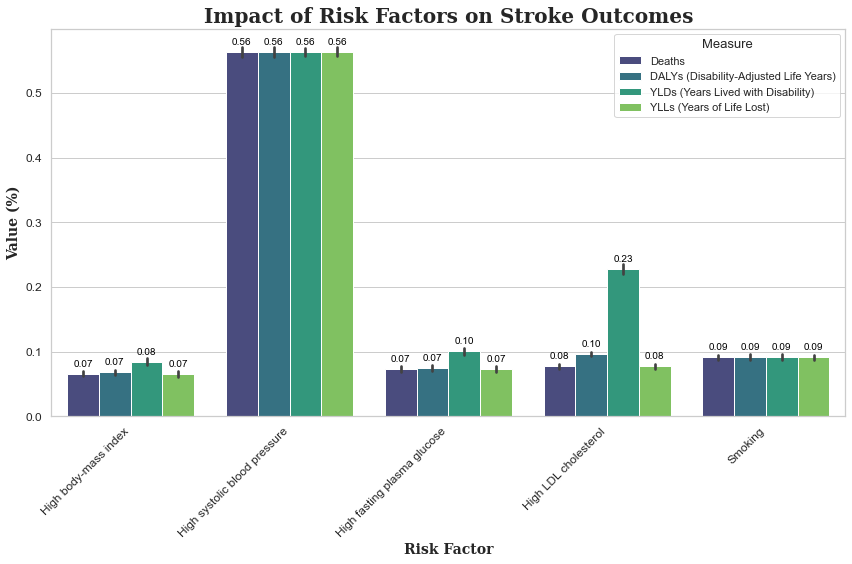

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and color palette
sns.set(style='whitegrid', palette='pastel')

# Distribution of measure values by risk factor
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='rei_name', y='val', hue='measure_name', data=df, palette='viridis')

# Add title and labels
plt.title('Impact of Risk Factors on Stroke Outcomes', fontsize=20, fontweight='bold', family='serif')
plt.xlabel('Risk Factor', fontsize=14, fontweight='bold', family='serif')
plt.ylabel('Value (%)', fontsize=14, fontweight='bold', family='serif')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add value annotations on bars with precise formatting
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', 
                fontsize=10, 
                color='black')

plt.legend(title='Measure', title_fontsize='13', fontsize='11')
plt.tight_layout()
plt.show()


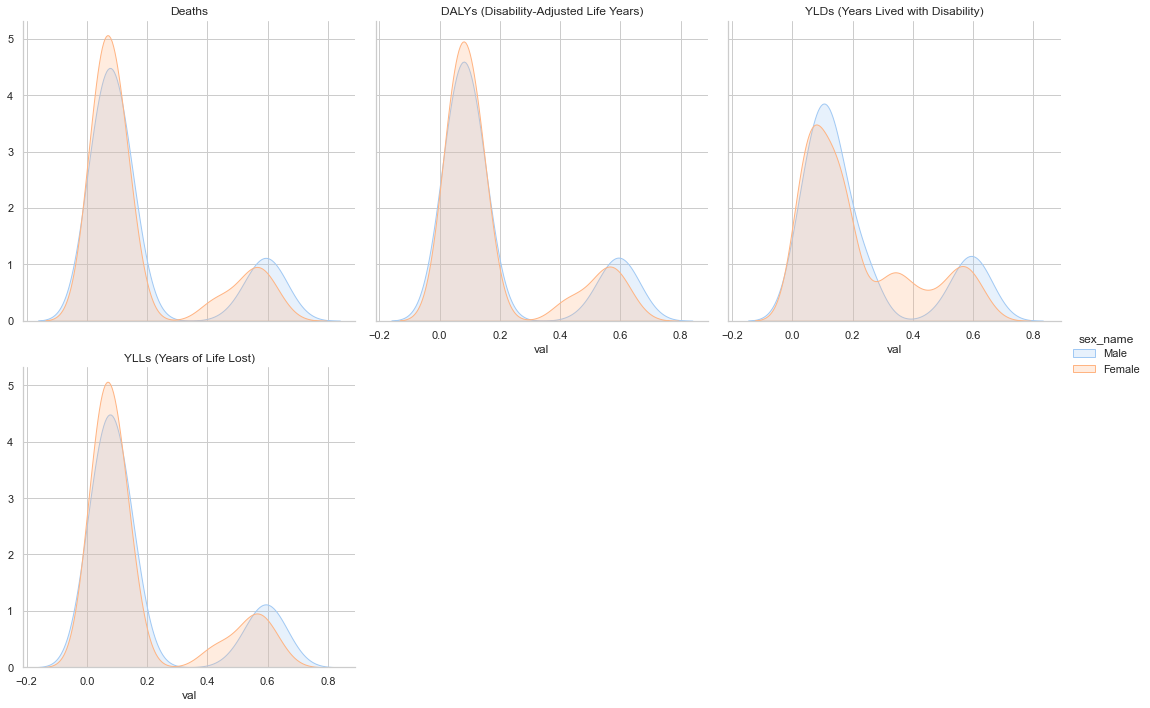

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(df, col='measure_name', hue='sex_name', col_wrap=3, height=5)
g.map(sns.kdeplot, 'val', shade=True)
g.add_legend()
g.set_titles('{col_name}')
plt.show()


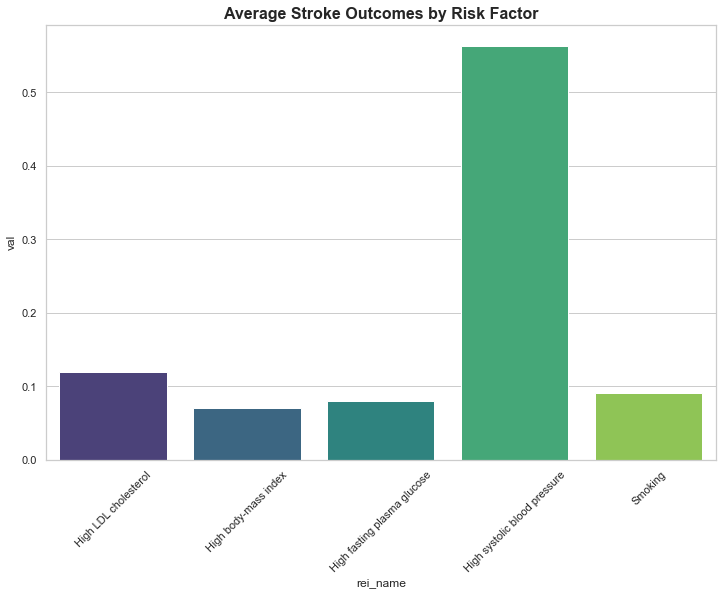

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

df_avg = df.groupby('rei_name')['val'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=df_avg, x='rei_name', y='val', palette='viridis')
plt.title('Average Stroke Outcomes by Risk Factor', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.show()


In [13]:
######################################FEATURE IMPORTANCE #########################################################

In [14]:
##################################DEFINING THE SPLITS#############################

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


# Sample structure: 'measure_name', 'sex_name', 'age_name', 'rei_name', 'year', 'val'

# Step 1: Pivot the dataset to get post-stroke outcomes in separate columns
df_pivot = df.pivot_table(index=['sex_name', 'age_name', 'rei_name', 'year'], 
                          columns='measure_name', 
                          values='val').reset_index()

# Step 2: One-Hot Encode categorical features
encoder = OneHotEncoder(sparse=False)
X = encoder.fit_transform(df_pivot[['sex_name', 'age_name', 'rei_name']])

# Step 3: Add 'year' as a feature
X = np.hstack([X, df_pivot[['year']].values])

# Step 4: Define the target variables (post-stroke outcomes)
y = df_pivot[['Deaths', 'DALYs (Disability-Adjusted Life Years)', 
              'YLDs (Years Lived with Disability)', 
              'YLLs (Years of Life Lost)']]

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
######################################## Random Forest#############################################

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import pandas as pd  # Import pandas to handle the results easily

# Step 1: Define the hyperparameters grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 300],   # Number of trees
    'max_depth': [10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required to be at a leaf node
}

# Step 2: Initialize the base model
base_model = RandomForestRegressor(random_state=42)

# Wrap the base model with MultiOutputRegressor
multi_output_model = MultiOutputRegressor(base_model)

# Step 3: Fit the model on the training set without tuning
multi_output_model.fit(X_train, y_train)

# Step 4: Predict on the test set before tuning
y_test_pred_before = multi_output_model.predict(X_test)

# Step 5: Evaluate the model performance on the test set before tuning
def calculate_metrics(y_true, y_pred):
    metrics = {}
    for i, col in enumerate(y_true.columns):
        mae = mean_absolute_error(y_true[col], y_pred[:, i])
        mse = mean_squared_error(y_true[col], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true[col], y_pred[:, i])
        
        metrics[col] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}
    return metrics

# Evaluate on the test set before tuning
print("\nTest Set Metrics Before Tuning:")
test_results_before = calculate_metrics(y_test, y_test_pred_before)

# Step 6: Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(multi_output_model.estimator, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Step 7: Fit the model on the training set with GridSearchCV
grid_search.fit(X_train, y_train)

# Step 8: Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Step 9: Train the model with the best hyperparameters
best_model = MultiOutputRegressor(RandomForestRegressor(**best_params, random_state=42))
best_model.fit(X_train, y_train)

# Step 10: Predict on the test set after tuning
y_test_pred_after = best_model.predict(X_test)

# Step 11: Evaluate the model performance on the test set after tuning
print("\nTest Set Metrics After Tuning:")
test_results_after = calculate_metrics(y_test, y_test_pred_after)

# Step 12: Create a summary table for results
summary_table = {
    "Model": ["Random Forest"] * 8,
    "Predicted Outcomes": ["Deaths", "DALYs", "YLLs", "YLDs"] * 2,
    "Condition": ["Before Tuning"] * 4 + ["After Tuning"] * 4,
    "Test MAE": [test_results_before[outcome]['MAE'] for outcome in y_test.columns] + 
                [test_results_after[outcome]['MAE'] for outcome in y_test.columns],
    "Test MSE": [test_results_before[outcome]['MSE'] for outcome in y_test.columns] + 
                [test_results_after[outcome]['MSE'] for outcome in y_test.columns],
    "Test RMSE": [test_results_before[outcome]['RMSE'] for outcome in y_test.columns] + 
                 [test_results_after[outcome]['RMSE'] for outcome in y_test.columns],
    "Test R²": [test_results_before[outcome]['R²'] for outcome in y_test.columns] + 
                [test_results_after[outcome]['R²'] for outcome in y_test.columns],
}

summary_df = pd.DataFrame(summary_table)

# Print the summary of the test set performance
print("\nSummary of Test Set Model Performance:")
print(summary_df)



Test Set Metrics Before Tuning:
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Test Set Metrics After Tuning:

Summary of Test Set Model Performance:
           Model Predicted Outcomes      Condition  Test MAE  Test MSE  \
0  Random Forest             Deaths  Before Tuning  0.000804  0.000001   
1  Random Forest              DALYs  Before Tuning  0.000790  0.000001   
2  Random Forest               YLLs  Before Tuning  0.001837  0.000009   
3  Random Forest               YLDs  Before Tuning  0.000813  0.000001   
4  Random Forest             Deaths   After Tuning  0.000768  0.000001   
5  Random Forest              DALYs   After Tuning  0.000774  0.000001   
6  Random Forest               YLLs   After Tuning  0.001782  0.000009   
7  Random Forest               YLDs   After Tuning  0.000772  0.000001   

   Test RMSE   Test R²  
0   0.001140  0.999968  
1   0.00

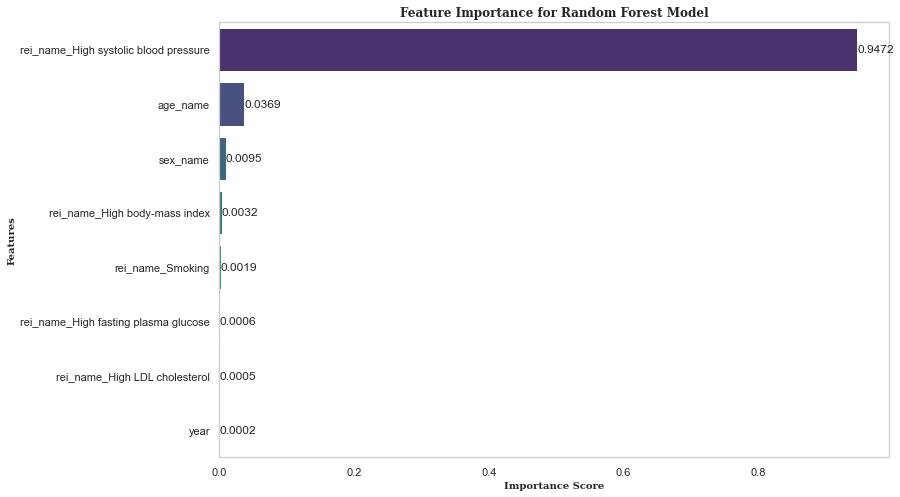

In [18]:
# Step 11: Get feature importances from the best model
feature_importances = best_model.estimators_[0].feature_importances_
feature_names = encoder.get_feature_names_out(['sex_name', 'age_name', 'rei_name'])
features = np.concatenate([feature_names, ['year']])

# Step 12: Combine importances for 'sex_name' and 'age_name'
combined_importances = {}
for feature, importance in zip(features, feature_importances):
    if 'sex_name' in feature:
        combined_importances['sex_name'] = combined_importances.get('sex_name', 0) + importance
    elif 'age_name' in feature:
        combined_importances['age_name'] = combined_importances.get('age_name', 0) + importance
    else:
        combined_importances[feature] = importance

# Convert the combined importances to a DataFrame
importance_df = pd.DataFrame({'Feature': list(combined_importances.keys()), 'Importance': list(combined_importances.values())})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 13: Plot feature importances with annotations
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Random Forest Model', fontsize=12, fontweight='bold', fontfamily='serif')
plt.xlabel('Importance Score', fontsize=10, fontweight='bold', fontfamily='serif')
plt.ylabel('Features', fontsize=10, fontweight='bold', fontfamily='serif')
plt.grid(axis='x', linestyle='--')

# Add annotations for the importance scores on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.4f}', va='center', fontsize=12)

plt.show()


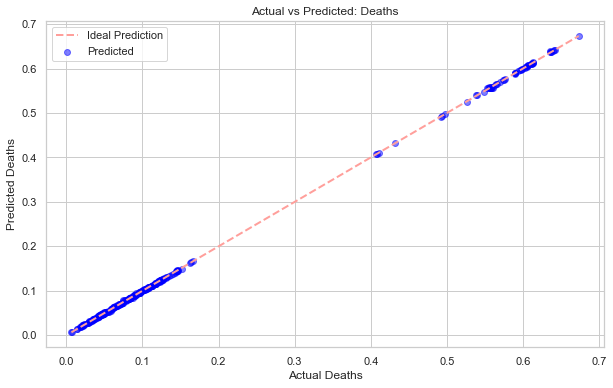

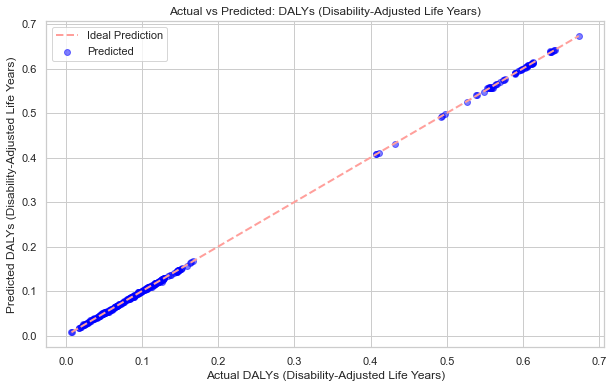

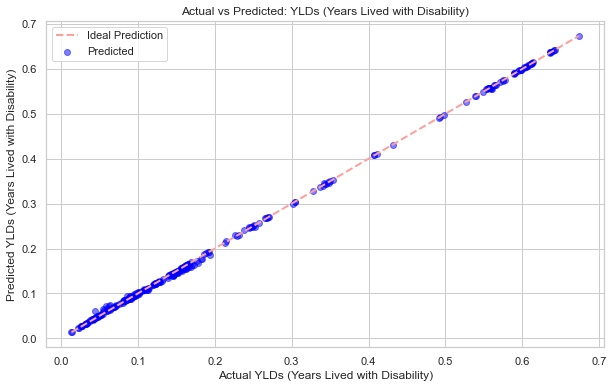

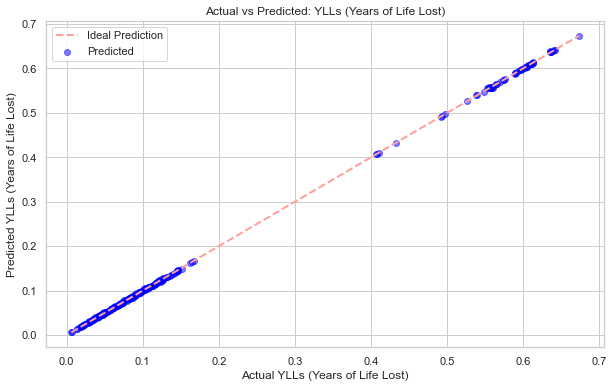

In [19]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred, outcome_name, outcome_index):
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for actual vs predicted values
    plt.scatter(y_true[outcome_name], y_pred[:, outcome_index], alpha=0.5, color='blue', label='Predicted')
    
    # Line for perfect prediction
    plt.plot([y_true[outcome_name].min(), y_true[outcome_name].max()], 
             [y_true[outcome_name].min(), y_true[outcome_name].max()], 'r--', lw=2, label='Ideal Prediction')
    
    plt.xlabel('Actual {}'.format(outcome_name))
    plt.ylabel('Predicted {}'.format(outcome_name))
    plt.title('Actual vs Predicted: {}'.format(outcome_name))
    plt.legend()
    plt.show()

# Outcomes to plot (based on column names)
outcomes = y_test.columns

# Plot actual vs predicted for each outcome
for i, outcome in enumerate(outcomes):
    plot_actual_vs_predicted(y_test, y_test_pred_before, outcome, i)


In [20]:
############################################ XGB REGRESSOR########################################################

In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import pandas as pd  # Import pandas to handle the results easily

# Step 1: Define the hyperparameters grid for XGBRegressor
param_grid = {
    'n_estimators': [100, 200, 300],    # Number of boosting stages to be run
    'max_depth': [3, 5, 7],              # Maximum depth of the individual estimators
    'learning_rate': [0.01, 0.05, 0.1],  # Step size for updating the weights
    'min_child_weight': [1, 2, 3],       # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 0.7, 1.0],        # Subsample ratio of the training instances
}

# Step 2: Initialize the base model
base_model = XGBRegressor(random_state=42, objective='reg:squarederror')

# Wrap the base model with MultiOutputRegressor
multi_output_model = MultiOutputRegressor(base_model)

# Step 3: Fit the model on the training set without tuning
multi_output_model.fit(X_train, y_train)

# Step 4: Predict on the test set before tuning
y_test_pred_before = multi_output_model.predict(X_test)

# Step 5: Evaluate the model performance on the test set before tuning
def calculate_metrics(y_true, y_pred):
    metrics = {}
    for i, col in enumerate(y_true.columns):
        mae = mean_absolute_error(y_true[col], y_pred[:, i])
        mse = mean_squared_error(y_true[col], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true[col], y_pred[:, i])
        
        metrics[col] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}
    return metrics

# Evaluate on the test set before tuning
print("\nTest Set Metrics Before Tuning:")
test_results_before = calculate_metrics(y_test, y_test_pred_before)

# Step 6: Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(multi_output_model.estimator, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Step 7: Fit the model on the training set with GridSearchCV
grid_search.fit(X_train, y_train)

# Step 8: Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Step 9: Train the model with the best hyperparameters
best_model = MultiOutputRegressor(XGBRegressor(**best_params, random_state=42, objective='reg:squarederror'))
best_model.fit(X_train, y_train)

# Step 10: Predict on the test set after tuning
y_test_pred_after = best_model.predict(X_test)

# Step 11: Evaluate the model performance on the test set after tuning
print("\nTest Set Metrics After Tuning:")
test_results_after = calculate_metrics(y_test, y_test_pred_after)

# Step 12: Create a summary table for results
summary_table = {
    "Model": ["XGBoost"] * 8,
    "Predicted Outcomes": ["Deaths", "DALYs", "YLLs", "YLDs"] * 2,
    "Condition": ["Before Tuning"] * 4 + ["After Tuning"] * 4,
    "Test MAE": [test_results_before[outcome]['MAE'] for outcome in y_test.columns] + 
                [test_results_after[outcome]['MAE'] for outcome in y_test.columns],
    "Test MSE": [test_results_before[outcome]['MSE'] for outcome in y_test.columns] + 
                [test_results_after[outcome]['MSE'] for outcome in y_test.columns],
    "Test RMSE": [test_results_before[outcome]['RMSE'] for outcome in y_test.columns] + 
                 [test_results_after[outcome]['RMSE'] for outcome in y_test.columns],
    "Test R²": [test_results_before[outcome]['R²'] for outcome in y_test.columns] + 
                [test_results_after[outcome]['R²'] for outcome in y_test.columns],
}

summary_df = pd.DataFrame(summary_table)

# Print the summary of the test set performance
print("\nSummary of Test Set Model Performance:")
print(summary_df)



Test Set Metrics Before Tuning:
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.7}

Test Set Metrics After Tuning:

Summary of Test Set Model Performance:
     Model Predicted Outcomes      Condition  Test MAE  Test MSE  Test RMSE  \
0  XGBoost             Deaths  Before Tuning  0.002373  0.000010   0.003180   
1  XGBoost              DALYs  Before Tuning  0.002698  0.000012   0.003458   
2  XGBoost               YLLs  Before Tuning  0.002947  0.000017   0.004111   
3  XGBoost               YLDs  Before Tuning  0.002465  0.000011   0.003257   
4  XGBoost             Deaths   After Tuning  0.001253  0.000003   0.001759   
5  XGBoost              DALYs   After Tuning  0.001453  0.000005   0.002138   
6  XGBoost               YLLs   After Tuning  0.001524  0.000004   0.002087   
7  XGBoost               YLDs   After Tuning  0.001301  0.000003   0.001848 

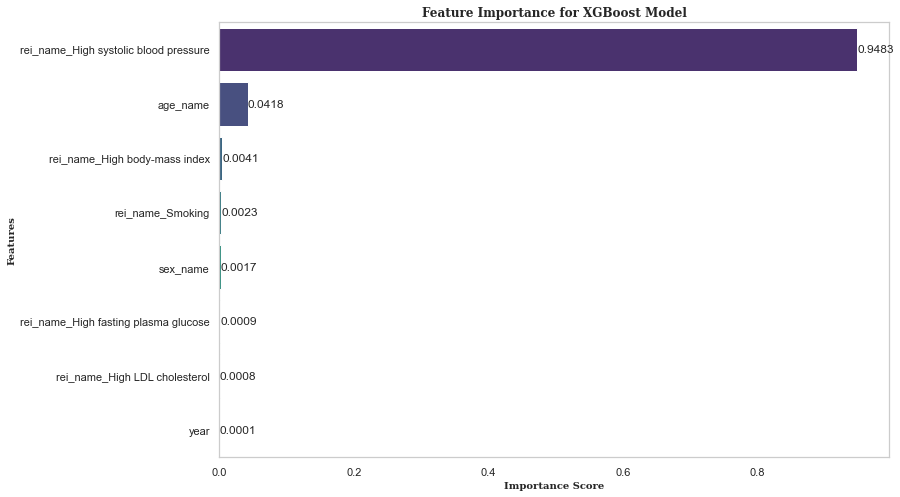

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# After fitting the best model (Step 9 in your code)
# Step 10: Get feature importances
feature_importances = best_model.estimators_[0].feature_importances_

# Get the original feature names
feature_names = encoder.get_feature_names_out(['sex_name', 'age_name', 'rei_name'])
features = np.concatenate([feature_names, ['year']])

# Step 11: Combine importances for 'sex_name' and 'age_name'
combined_importances = {}
for feature, importance in zip(features, feature_importances):
    if 'sex_name' in feature:
        combined_importances['sex_name'] = combined_importances.get('sex_name', 0) + importance
    elif 'age_name' in feature:
        combined_importances['age_name'] = combined_importances.get('age_name', 0) + importance
    else:
        combined_importances[feature] = importance

# Convert the combined importances to a DataFrame
importance_df = pd.DataFrame({'Feature': list(combined_importances.keys()), 'Importance': list(combined_importances.values())})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 12: Plot feature importances with annotations
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for XGBoost Model', fontsize=12, fontweight='bold', fontfamily='serif')
plt.xlabel('Importance Score', fontsize=10, fontweight='bold', fontfamily='serif')
plt.ylabel('Features', fontsize=10, fontweight='bold', fontfamily='serif')
plt.grid(axis='x', linestyle='--')

# Add annotations for the importance scores on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.4f}', va='center', fontsize=12)

plt.show()

In [23]:
############################################### DECISION TREESS #################################################

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import pandas as pd  # Import pandas to handle the results easily

# Step 1: Define the hyperparameters grid for DecisionTreeRegressor
param_grid = {
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
}

# Step 2: Initialize the base model
base_model = DecisionTreeRegressor(random_state=42)

# Wrap the base model with MultiOutputRegressor
multi_output_model = MultiOutputRegressor(base_model)

# Step 3: Fit the model on the training set without tuning
multi_output_model.fit(X_train, y_train)

# Step 4: Predict on the test set before tuning
y_test_pred_before = multi_output_model.predict(X_test)

# Step 5: Evaluate the model performance on the test set before tuning
def calculate_metrics(y_true, y_pred):
    metrics = {}
    for i, col in enumerate(y_true.columns):
        mae = mean_absolute_error(y_true[col], y_pred[:, i])
        mse = mean_squared_error(y_true[col], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true[col], y_pred[:, i])
        
        metrics[col] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}
    return metrics

# Evaluate on the test set before tuning
print("\nTest Set Metrics Before Tuning:")
test_results_before = calculate_metrics(y_test, y_test_pred_before)

# Step 6: Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(multi_output_model.estimator, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Step 7: Fit the model on the training set with GridSearchCV
grid_search.fit(X_train, y_train)

# Step 8: Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Step 9: Train the model with the best hyperparameters
best_model = MultiOutputRegressor(DecisionTreeRegressor(**best_params, random_state=42))
best_model.fit(X_train, y_train)

# Step 10: Predict on the test set after tuning
y_test_pred_after = best_model.predict(X_test)

# Step 11: Evaluate the model performance on the test set after tuning
print("\nTest Set Metrics After Tuning:")
test_results_after = calculate_metrics(y_test, y_test_pred_after)

# Step 12: Create a summary table for results
summary_table = {
    "Model": ["Decision Tree"] * 8,
    "Predicted Outcomes": ["Deaths", "DALYs", "YLLs", "YLDs"] * 2,
    "Condition": ["Before Tuning"] * 4 + ["After Tuning"] * 4,
    "Test MAE": [test_results_before[outcome]['MAE'] for outcome in y_test.columns] + 
                [test_results_after[outcome]['MAE'] for outcome in y_test.columns],
    "Test MSE": [test_results_before[outcome]['MSE'] for outcome in y_test.columns] + 
                [test_results_after[outcome]['MSE'] for outcome in y_test.columns],
    "Test RMSE": [test_results_before[outcome]['RMSE'] for outcome in y_test.columns] + 
                 [test_results_after[outcome]['RMSE'] for outcome in y_test.columns],
    "Test R²": [test_results_before[outcome]['R²'] for outcome in y_test.columns] + 
                [test_results_after[outcome]['R²'] for outcome in y_test.columns],
}

summary_df = pd.DataFrame(summary_table)

# Print the summary of the test set performance
print("\nSummary of Test Set Model Performance:")
print(summary_df)



Test Set Metrics Before Tuning:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Test Set Metrics After Tuning:

Summary of Test Set Model Performance:
           Model Predicted Outcomes      Condition  Test MAE  Test MSE  \
0  Decision Tree             Deaths  Before Tuning  0.000867  0.000001   
1  Decision Tree              DALYs  Before Tuning  0.000885  0.000001   
2  Decision Tree               YLLs  Before Tuning  0.001086  0.000003   
3  Decision Tree               YLDs  Before Tuning  0.000867  0.000001   
4  Decision Tree             Deaths   After Tuning  0.000867  0.000001   
5  Decision Tree              DALYs   After Tuning  0.000885  0.000001   
6  Decision Tree               YLLs   After Tuning  0.001086  0.000003   
7  Decision Tree               YLDs   After Tuning  0.000867  0.000001   

   Test RMSE   Test R²  
0   0.001209  0.999965  
1   0.001200  0.999964  
2 

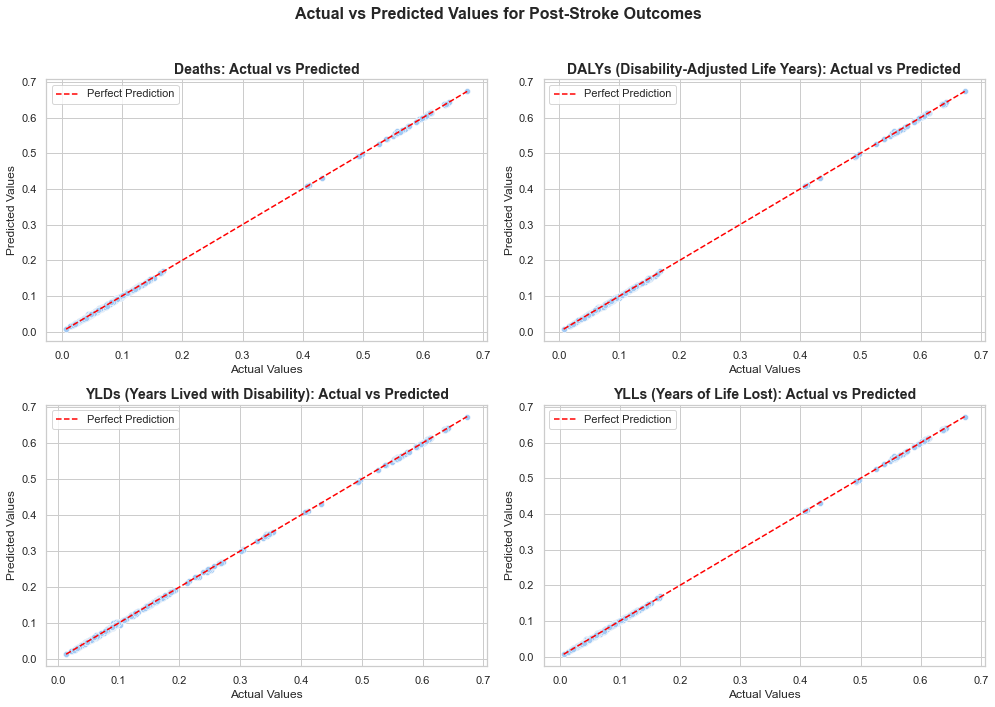

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Set up a 2x2 grid for plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Actual vs Predicted Values for Post-Stroke Outcomes', fontsize=16, fontweight='bold')

# List of outcomes to plot
outcomes = ['Deaths', 'DALYs (Disability-Adjusted Life Years)', 
              'YLDs (Years Lived with Disability)', 
              'YLLs (Years of Life Lost)']

# Plot settings for the axes
plot_settings = [
    (0, 0),  # Top-left (Deaths)
    (0, 1),  # Top-right (DALYs)
    (1, 0),  # Bottom-left (YLLs)
    (1, 1)   # Bottom-right (YLDs)
]

# Step 2: Plot each outcome's actual vs predicted values
for i, outcome in enumerate(outcomes):
    ax = axs[plot_settings[i][0], plot_settings[i][1]]  # Select the axis for the current plot
    
    # Plot actual vs predicted values
    sns.scatterplot(x=y_test[outcome], y=y_test_pred_after[:, i], ax=ax)
    sns.lineplot(x=y_test[outcome], y=y_test[outcome], color='red', linestyle='--', ax=ax, label='Perfect Prediction')

    # Add labels and title
    ax.set_title(f'{outcome}: Actual vs Predicted', fontsize=14, fontweight='bold')
    ax.set_xlabel('Actual Values', fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=12)
    ax.legend()

# Step 3: Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
plt.show()

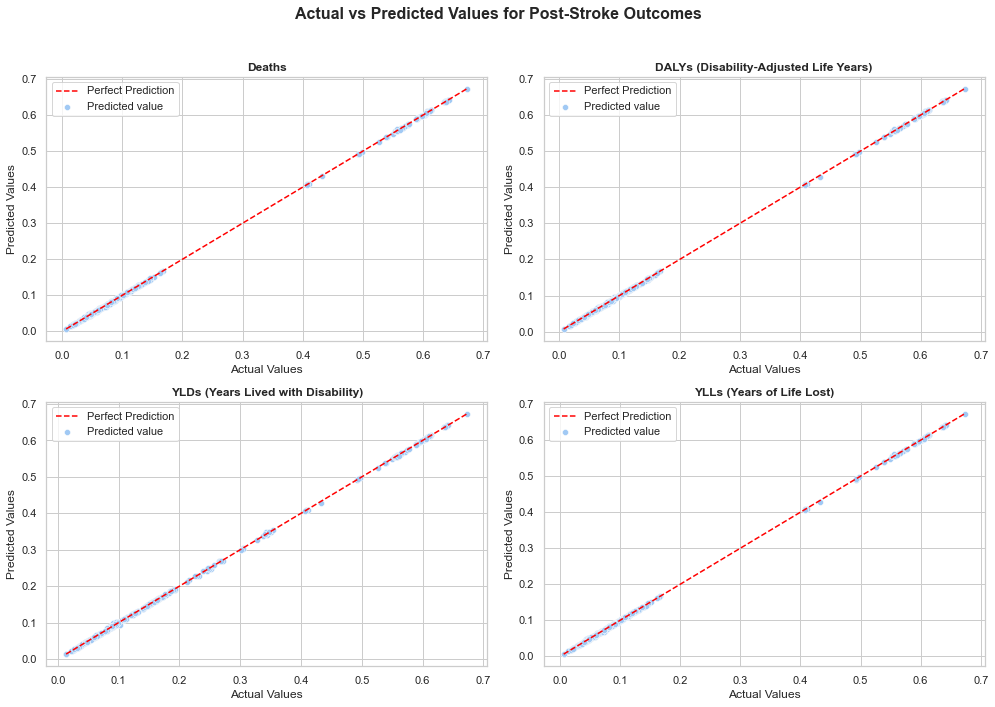

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Set up a 2x2 grid for plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Actual vs Predicted Values for Post-Stroke Outcomes', fontsize=16, fontweight='bold')

# List of outcomes to plot
outcomes = ['Deaths', 'DALYs (Disability-Adjusted Life Years)', 
              'YLDs (Years Lived with Disability)', 
              'YLLs (Years of Life Lost)']

# Plot settings for the axes
plot_settings = [
    (0, 0),  # Top-left (Deaths)
    (0, 1),  # Top-right (DALYs)
    (1, 0),  # Bottom-left (YLLs)
    (1, 1)   # Bottom-right (YLDs)
]

# Step 2: Define color palette and plot each outcome's actual vs predicted values
for i, outcome in enumerate(outcomes):
    ax = axs[plot_settings[i][0], plot_settings[i][1]]  # Select the axis for the current plot
    
    # Use seaborn's color palette for scatterplot
    sns.scatterplot(x=y_test[outcome], y=y_test_pred_after[:, i], ax=ax, 
                    color='b', label='Predicted value')
    
    # Line plot for the perfect prediction
    ax.plot([min(y_test[outcome]), max(y_test[outcome])], [min(y_test[outcome]), max(y_test[outcome])], 
            color='red', linestyle='--', label='Perfect Prediction')

    # Add labels and title
    ax.set_title(f'{outcome}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Actual Values', fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=12)
    ax.legend()

# Step 3: Adjust the layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
plt.show()

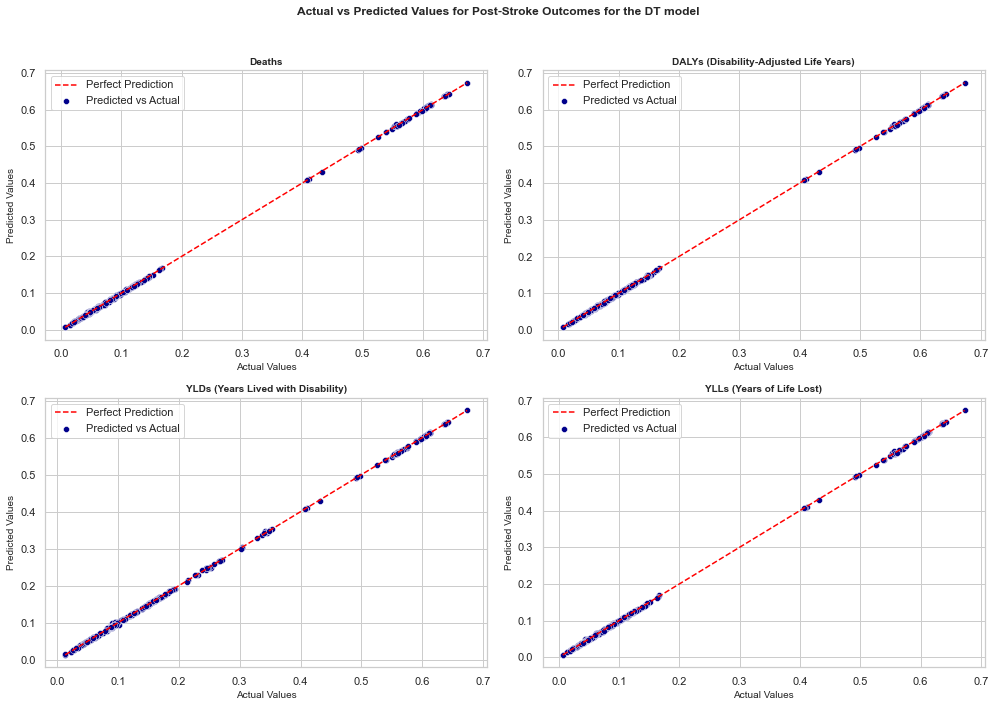

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Set up a 2x2 grid for plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Actual vs Predicted Values for Post-Stroke Outcomes for the DT model', fontsize=12, fontweight='bold')

# List of outcomes to plot
outcomes = ['Deaths', 'DALYs (Disability-Adjusted Life Years)', 
              'YLDs (Years Lived with Disability)', 
              'YLLs (Years of Life Lost)']

# Plot settings for the axes
plot_settings = [
    (0, 0),  # Top-left (Deaths)
    (0, 1),  # Top-right (DALYs)
    (1, 0),  # Bottom-left (YLLs)
    (1, 1)   # Bottom-right (YLDs)
]

# Step 2: Use darker colors and plot each outcome's actual vs predicted values
for i, outcome in enumerate(outcomes):
    ax = axs[plot_settings[i][0], plot_settings[i][1]]  # Select the axis for the current plot
    
    # Use a dark blue color for the scatterplot
    sns.scatterplot(x=y_test[outcome], y=y_test_pred_after[:, i], ax=ax, 
                    color='darkblue', label='Predicted vs Actual')
    
    # Line plot for the perfect prediction
    ax.plot([min(y_test[outcome]), max(y_test[outcome])], [min(y_test[outcome]), max(y_test[outcome])], 
            color='red', linestyle='--', label='Perfect Prediction')

    # Add labels and title
    ax.set_title(f'{outcome}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Actual Values', fontsize=10)
    ax.set_ylabel('Predicted Values', fontsize=10)
    ax.legend()

# Step 3: Adjust the layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
plt.show()


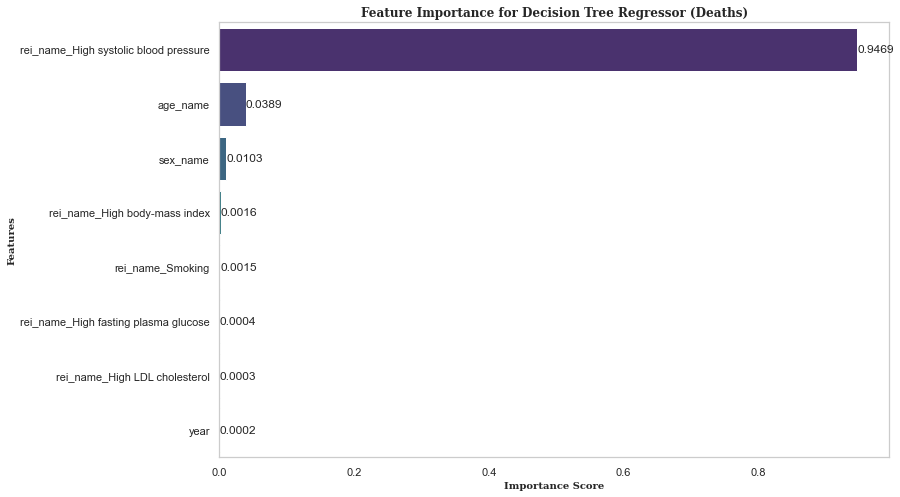

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Step 1: Get the feature names (ensure these match your features in X_train)
feature_names = encoder.get_feature_names_out(['sex_name', 'age_name', 'rei_name'])
features = np.concatenate([feature_names, ['year']])  # Adjust based on your dataset

# Step 2: Get feature importances from the first target's estimator (e.g., 'Deaths')
# You can loop through the estimators for other targets (DALYs, YLLs, YLDs) similarly
feature_importances = best_model.estimators_[0].feature_importances_  # For the first target (Deaths)

# Step 3: Combine importances for 'sex_name' and 'age_name' similar to your XGBoost code
combined_importances = {}
for feature, importance in zip(features, feature_importances):
    if 'sex_name' in feature:
        combined_importances['sex_name'] = combined_importances.get('sex_name', 0) + importance
    elif 'age_name' in feature:
        combined_importances['age_name'] = combined_importances.get('age_name', 0) + importance
    else:
        combined_importances[feature] = importance

# Step 4: Convert the combined importances to a DataFrame
importance_df = pd.DataFrame({'Feature': list(combined_importances.keys()), 'Importance': list(combined_importances.values())})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 5: Plot feature importances with annotations
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Decision Tree Regressor (Deaths)', fontsize=12, fontweight='bold', fontfamily='serif')
plt.xlabel('Importance Score', fontsize=10, fontweight='bold', fontfamily='serif')
plt.ylabel('Features', fontsize=10, fontweight='bold', fontfamily='serif')
plt.grid(axis='x', linestyle='--')

# Add annotations for the importance scores on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.4f}', va='center', fontsize=12)

plt.show()


In [29]:
#################################################### HYBRIDIZING ####################################################

In [30]:
from sklearn.ensemble import StackingRegressor

# Step 1: Initialize the base models (Random Forest, XGBoost, Decision Tree)
base_models = [
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgboost', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('decision_tree', DecisionTreeRegressor(random_state=42))
]


# Step 2: Initialize the meta-model (we'll use Random Forest here)
meta_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Step 4: Fit separate stacking models for each target (Deaths, DALYs, YLLs, YLDs)

# Initialize a dictionary to store the models for each outcome
stacking_models = {}

# Loop over each target (Deaths, DALYs, YLLs, YLDs)
for target in y_train.columns:
    # Create a new stacking model for each outcome
    stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
    
    # Fit the stacking model for the current outcome
    stacking_model.fit(X_train, y_train[target])
    
    # Store the fitted model in the dictionary
    stacking_models[target] = stacking_model

# Step 5: Make predictions for each target
y_test_pred = np.column_stack([stacking_models[target].predict(X_test) for target in y_test.columns])

# Step 6: Calculate metrics for each outcome
test_results = calculate_metrics(y_test, y_test_pred)

# Step 7: Create a summary table for the results
summary_table = {
    "Model": ["Stacking Ensemble Model"] * 4,
    "Predicted Outcomes": ["Deaths", "DALYs", "YLLs", "YLDs"],
    "Test MAE": [test_results[outcome]['MAE'] for outcome in y_test.columns],
    "Test MSE": [test_results[outcome]['MSE'] for outcome in y_test.columns],
    "Test RMSE": [test_results[outcome]['RMSE'] for outcome in y_test.columns],
    "Test R²": [test_results[outcome]['R²'] for outcome in y_test.columns],
}

summary_df = pd.DataFrame(summary_table)

# Print the summary of the test set performance
print("\nSummary of Test Set Model Performance for Stacking Hybrid Model:")
print(summary_df)



Summary of Test Set Model Performance for Stacking Hybrid Model:
                     Model Predicted Outcomes  Test MAE  Test MSE  Test RMSE  \
0  Stacking Ensemble Model             Deaths  0.000906  0.000001   0.001224   
1  Stacking Ensemble Model              DALYs  0.000868  0.000001   0.001197   
2  Stacking Ensemble Model               YLLs  0.001225  0.000003   0.001722   
3  Stacking Ensemble Model               YLDs  0.000883  0.000001   0.001185   

    Test R²  
0  0.999964  
1  0.999964  
2  0.999921  
3  0.999966  


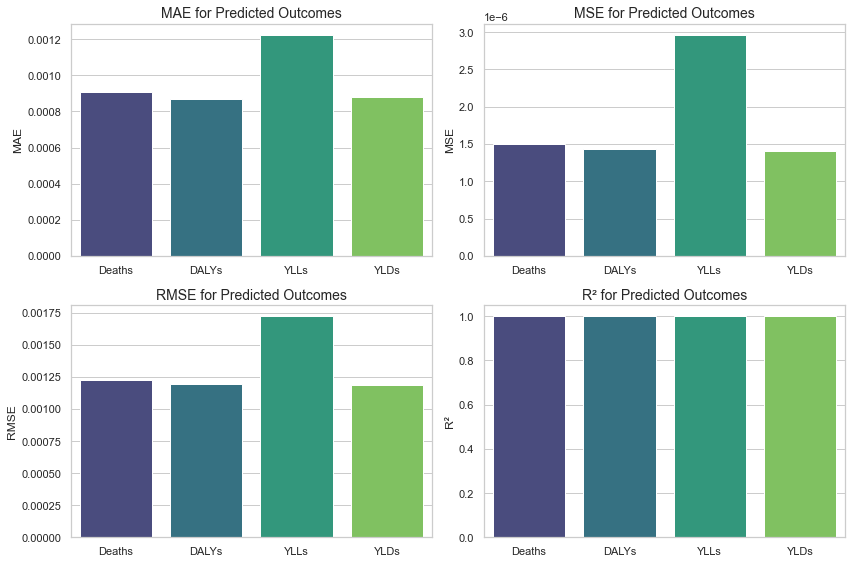

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing Test MAE, MSE, RMSE, and R² for each predicted outcome
metrics_df = pd.DataFrame({
    'Predicted Outcomes': ['Deaths', 'DALYs', 'YLLs', 'YLDs'],
    'MAE': summary_df['Test MAE'],
    'MSE': summary_df['Test MSE'],
    'RMSE': summary_df['Test RMSE'],
    'R²': summary_df['Test R²']
})

# Set the figure size
plt.figure(figsize=(12, 8))

# Create subplots for each metric
for i, metric in enumerate(['MAE', 'MSE', 'RMSE', 'R²']):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Predicted Outcomes', y=metric, data=metrics_df, palette='viridis')
    plt.title(f'{metric} for Predicted Outcomes', fontsize=14)
    plt.ylabel(metric, fontsize=12)
    plt.xlabel('')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [33]:
############################################# HYBRID TRIAL #########################################################

In [34]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Step 1: Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initialize the models
decision_tree = DecisionTreeRegressor(random_state=42)
neural_network = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)

# Step 3: Fit the models separately
decision_tree.fit(X_train, y_train)
neural_network.fit(X_train, y_train)

# Step 4: Make predictions with both models
dt_predictions = decision_tree.predict(X_test)
nn_predictions = neural_network.predict(X_test)

# Step 5: Combine the predictions (simple average here)
hybrid_predictions = (dt_predictions + nn_predictions) / 2

# Step 6: Evaluate the hybrid model
mse_hybrid = mean_squared_error(y_test, hybrid_predictions)
mse_dt = mean_squared_error(y_test, dt_predictions)
mse_nn = mean_squared_error(y_test, nn_predictions)

print(f'Mean Squared Error of Decision Tree: {mse_dt:.2f}')
print(f'Mean Squared Error of Neural Network: {mse_nn:.2f}')
print(f'Mean Squared Error of Hybrid Model: {mse_hybrid:.2f}')

Mean Squared Error of Decision Tree: 6350.43
Mean Squared Error of Neural Network: 65.62
Mean Squared Error of Hybrid Model: 1609.49


C:\Users\2023\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Step 1: Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Initialize the models with adjusted parameters
decision_tree = DecisionTreeRegressor(random_state=42, max_depth=5)  # Limit depth to avoid overfitting
neural_network = MLPRegressor(hidden_layer_sizes=(50,), max_iter=2000, learning_rate_init=0.01, random_state=42)

# Step 4: Fit the models separately
decision_tree.fit(X_train, y_train)
neural_network.fit(X_train, y_train)

# Step 5: Make predictions with both models
dt_predictions = decision_tree.predict(X_test)
nn_predictions = neural_network.predict(X_test)

# Step 6: Combine the predictions (simple average here)
hybrid_predictions = (dt_predictions + nn_predictions) / 2

# Step 7: Evaluate the hybrid model
mse_hybrid = mean_squared_error(y_test, hybrid_predictions)
mse_dt = mean_squared_error(y_test, dt_predictions)
mse_nn = mean_squared_error(y_test, nn_predictions)

print(f'Mean Squared Error of Decision Tree: {mse_dt:.2f}')
print(f'Mean Squared Error of Neural Network: {mse_nn:.2f}')
print(f'Mean Squared Error of Hybrid Model: {mse_hybrid:.2f}')

Mean Squared Error of Decision Tree: 6512.20
Mean Squared Error of Neural Network: 1.82
Mean Squared Error of Hybrid Model: 1626.68
